# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_0m_3f_230404_2"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [40, 1860]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 18062
Frames resolution: 1080 x 1920


In [7]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [8]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,1516.332994,880.714751,1517.748703,873.967560,0.0,1557.000000,750.000000,0.505882,1520.000000,811.000000,-0.508190,14745.0,301.682163,96.416781,0.947553,7
1,1,0,879.813777,989.409976,872.681765,984.644150,0.0,740.000000,949.000000,0.549020,732.000000,949.000000,1.053259,2105.0,116.673034,81.289789,0.717332,7
2,2,0,639.884983,1002.954655,643.632446,1001.615183,NaN,639.884983,1002.954655,NaN,639.884983,1002.954655,-1.086495,7851.0,160.562866,91.939099,0.819831,7
3,3,0,1022.715531,1012.403304,1021.587978,1012.030613,NaN,1022.715531,1012.403304,NaN,1022.715531,1012.403304,1.565551,8718.0,219.102158,102.068412,0.884864,7
4,4,0,857.862348,1032.558704,854.678786,1031.933318,NaN,857.862348,1032.558704,NaN,857.862348,1032.558704,1.440302,247.0,193.675616,51.519943,0.963970,7
5,5,0,685.570481,1041.968491,692.821184,1042.646744,NaN,685.570481,1041.968491,NaN,685.570481,1041.968491,1.480577,603.0,99.939198,33.943983,0.940553,7


In [11]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([0, 2, 3])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        -tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1],
        -tracking_0["orientation"].values[1]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x   position_y  orientation
0   0     0         7  1516.332994   880.714751    -0.508190
1   1     0         7   879.813777   989.409976     1.053259
2   2     0         7   639.884983  1002.954655    -1.086495
3   3     0         7  1022.715531  1012.403304     1.565551
4   4     0         7   857.862348  1032.558704     1.440302
5   5     0         7   685.570481  1041.968491     1.480577
6   6     0         7  1338.468453  1060.773869    -1.562120


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,1516.332994,880.714751,1517.748703,873.967560,0.0,1557.000000,750.000000,0.505882,1520.000000,811.000000,0.508190,14745.0,301.682163,96.416781,0.947553,7
2,1,0,639.884983,1002.954655,643.632446,1001.615183,NaN,639.884983,1002.954655,NaN,639.884983,1002.954655,1.086495,7851.0,160.562866,91.939099,0.819831,7
3,2,0,1022.715531,1012.403304,1021.587978,1012.030613,NaN,1022.715531,1012.403304,NaN,1022.715531,1012.403304,1.086495,8718.0,219.102158,102.068412,0.884864,7
7,0,3,1516.323614,880.860063,1517.682776,874.262387,0.0,1556.000000,750.000000,0.505882,1561.000000,811.000000,-0.508187,14678.0,301.759940,96.303596,0.947708,8
8,1,3,879.217980,989.074915,871.282172,983.928363,0.0,731.000000,948.000000,0.600000,728.000000,947.000000,1.083679,2069.0,120.916267,82.280364,0.732772,8
9,2,3,639.828065,1002.947362,643.632521,1001.606125,NaN,639.828065,1002.947362,NaN,639.828065,1002.947362,-1.085174,7846.0,160.696359,92.002503,0.819888,8
10,3,3,787.874683,994.363636,789.342266,993.743337,NaN,787.874683,994.363636,NaN,787.874683,994.363636,-1.257699,2761.0,113.560106,82.935677,0.683101,8


In [12]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
36708,3,18057,1736.737864,897.585761,1738.453880,890.726519,NaN,1736.737864,897.585761,NaN,1736.737864,897.585761,-0.231337,309.0,182.241146,31.872864,0.984587,4
36709,0,18060,1141.302861,768.865117,1146.256394,759.010989,0.0,1200.000000,653.000000,0.603922,1200.000000,658.000000,-0.744590,20729.0,292.324589,105.145094,0.933073,4
36710,1,18060,1687.562551,785.395389,1685.371166,782.014973,0.0,1683.000000,660.000000,0.592157,1668.000000,683.000000,0.299791,11103.0,278.676367,94.293436,0.941016,4
36711,2,18060,1513.738190,898.327698,1512.542129,897.925094,NaN,1513.738190,898.327698,NaN,1513.738190,898.327698,-0.654458,12066.0,281.019974,104.563712,0.928198,4
36712,3,18060,1739.460000,881.950000,1739.043588,882.874029,NaN,1739.460000,881.950000,NaN,1739.460000,881.950000,-0.225444,200.0,191.499730,36.008162,0.982163,4


## Velocities distribution in each frame

In [13]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


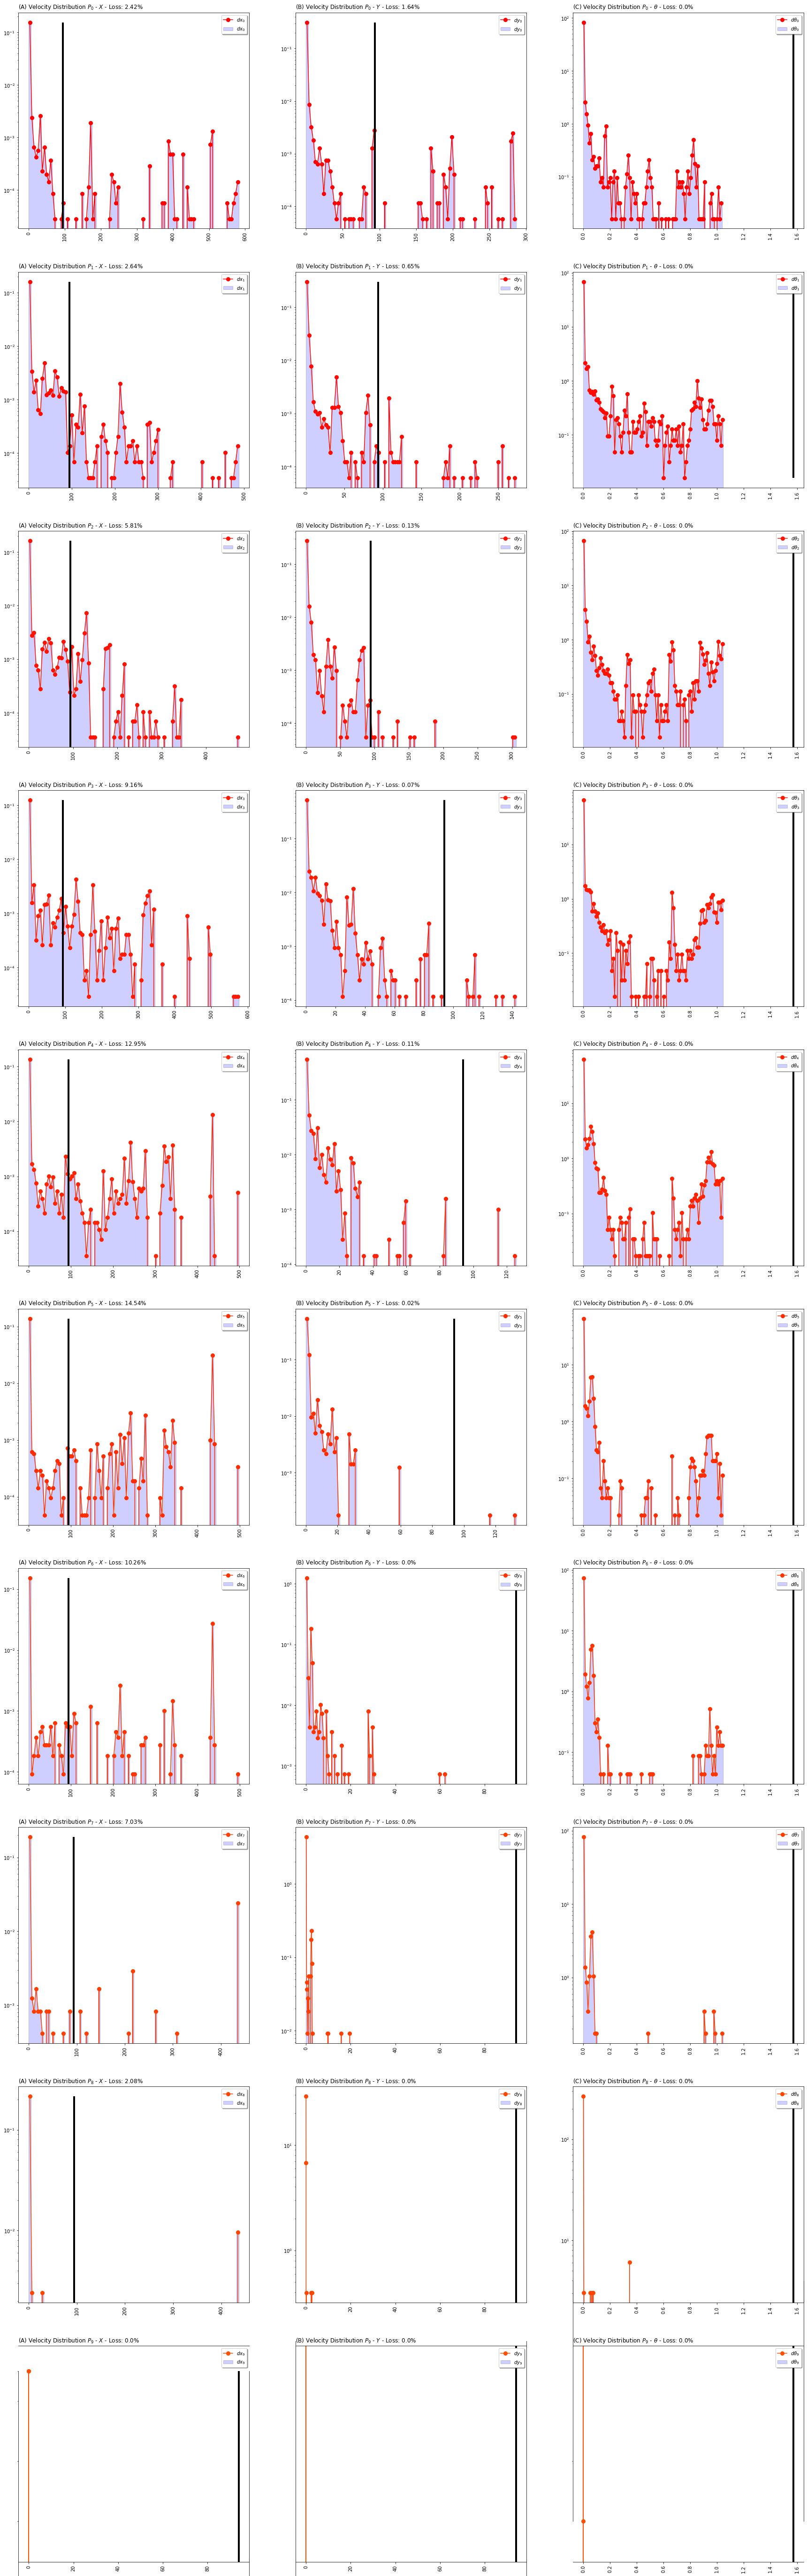

In [14]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [15]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,2
1,3,69
2,4,1708
3,5,6725
4,6,12126
5,7,11539
6,8,3672
7,9,828
8,10,40


## Clustering frames

In [16]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 54.38703563497845 



In [17]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [18]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.002724
1,2,True,False,False,0.002724
2,3,False,False,False,0.177068
3,3,True,False,False,0.010897
4,4,False,False,False,4.453949
5,4,False,True,False,0.005448
6,4,True,False,False,0.171620
7,4,True,True,False,0.021793
8,5,False,False,False,17.066659
9,5,False,True,False,0.027241


In [19]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 52.56406856752691 
	- Angle: 54.38703563497845 



In [20]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.0%
Final loss data X-axis: 0.13840447323257488%
Final loss data Y-axis: 0.04428943143442396%
Final loss data Angle : 0.2712727675358467%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.016609
1,3,False,False,True,0.027681
2,3,False,True,False,0.011072
3,3,False,True,True,0.083043
4,3,True,True,False,0.243592
5,3,True,True,True,99.618004


In [21]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 52.56406856752691 
	- Angle: 54.38703563497845 



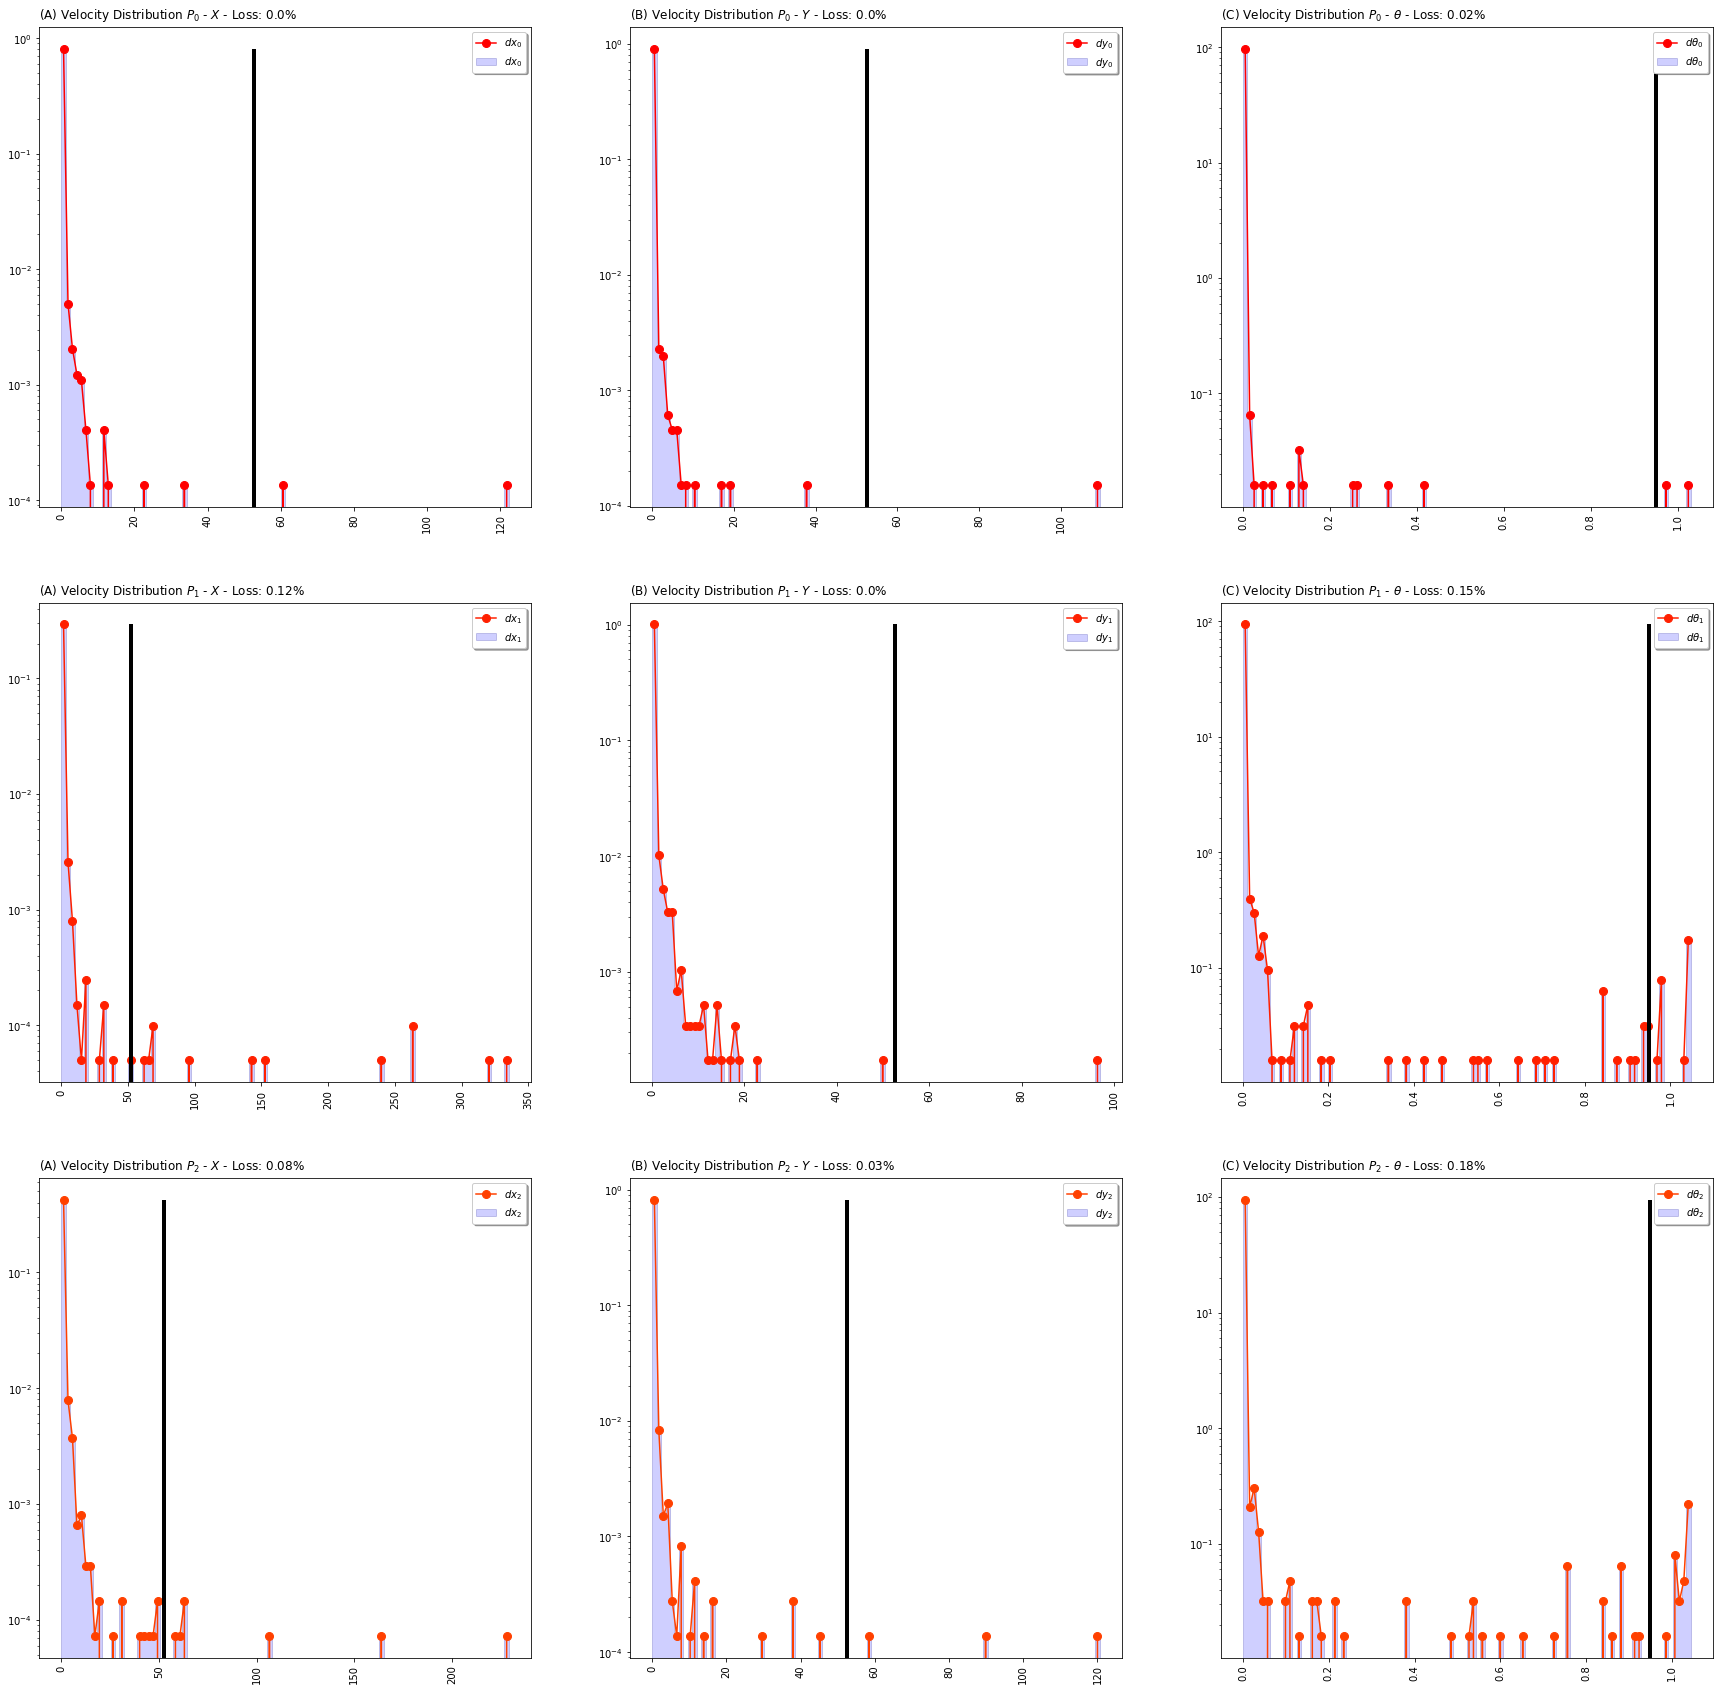

In [22]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [23]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [24]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1516.332994,880.714751,1517.748703,873.967560,0.0,1557.000000,750.000000,0.505882,1520.000000,811.000000,0.508190,14745.0,301.682163,96.416781,0.947553,3,NaN,NaN,NaN,NaN,False,False,False
24,1,0,639.884983,1002.954655,643.632446,1001.615183,NaN,639.884983,1002.954655,NaN,639.884983,1002.954655,1.086495,7851.0,160.562866,91.939099,0.819831,3,NaN,NaN,NaN,NaN,False,False,False
48,2,0,1022.715531,1012.403304,1021.587978,1012.030613,NaN,1022.715531,1012.403304,NaN,1022.715531,1012.403304,1.086495,8718.0,219.102158,102.068412,0.884864,3,NaN,NaN,NaN,NaN,False,False,False
72,0,3,1516.323614,880.860063,1517.682776,874.262387,0.0,1556.000000,750.000000,0.505882,1561.000000,811.000000,-0.508187,14678.0,301.759940,96.303596,0.947708,3,3.0,-0.003127,0.048437,-0.338792,False,False,False
73,1,3,662.798521,1022.459654,668.393529,1022.136248,NaN,662.798521,1022.459654,NaN,662.798521,1022.459654,-1.085174,7846.0,160.696359,92.002503,0.819888,3,3.0,7.637846,6.501666,-0.723890,False,False,False
74,2,3,1022.740205,1012.408020,1021.527959,1012.027064,NaN,1022.740205,1012.408020,NaN,1022.740205,1012.408020,1.564106,8703.0,219.226507,101.977572,0.885221,3,3.0,0.008224,0.001572,0.159204,False,False,False
75,0,6,1516.557219,880.153740,1517.851390,873.460361,0.0,1557.000000,750.000000,0.505882,1520.000000,811.000000,-0.508226,14427.0,303.593789,97.212116,0.947348,3,3.0,0.077869,-0.235441,-0.000013,False,False,False
76,1,6,641.436206,1003.004585,645.365900,1002.673463,NaN,641.436206,1003.004585,NaN,641.436206,1003.004585,-1.227257,7634.0,163.298767,99.536810,0.792757,3,3.0,-7.120772,-6.485023,-0.047361,False,False,False
77,2,6,1022.796231,1012.633216,1021.808991,1012.305003,NaN,1022.796231,1012.633216,NaN,1022.796231,1012.633216,1.566271,8809.0,218.497635,102.284458,0.883662,3,3.0,0.018676,0.075065,0.000722,False,False,False


## Visualize final data

In [25]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


In [26]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_0m_3f_230404_2_c.zip'